In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

E:\anaconda3\envs\jcopml2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from luwiji.random_forest import illustration

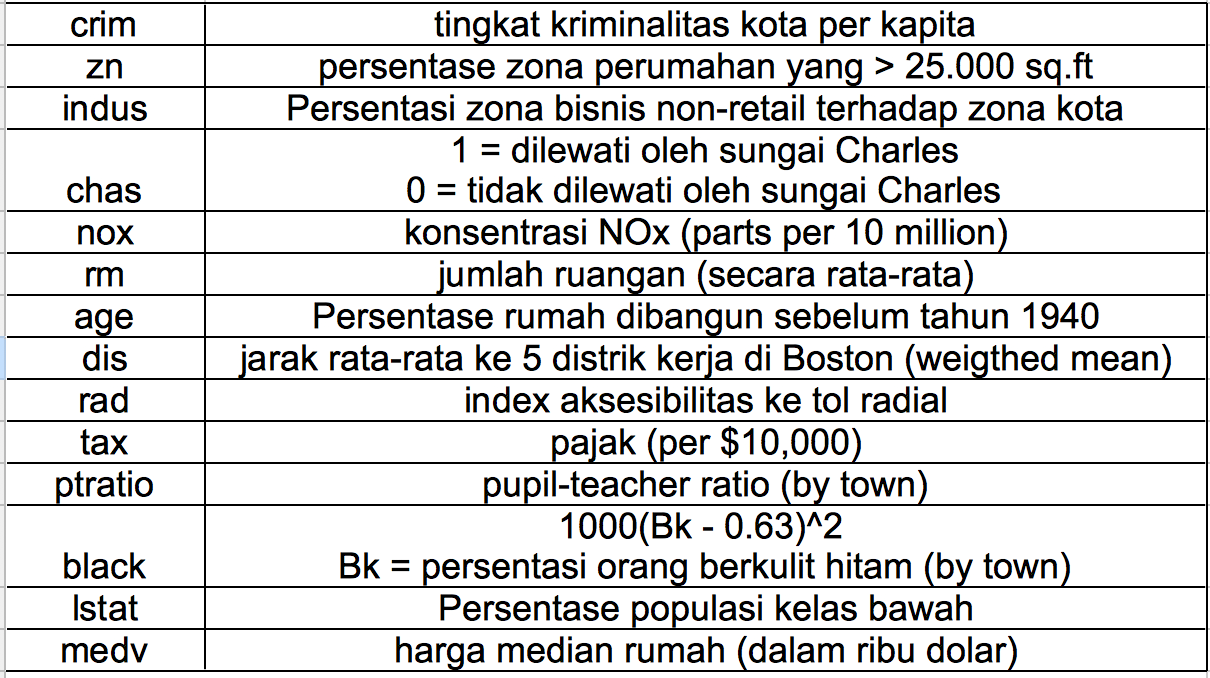

In [3]:
illustration.nomenklatur_house

# Import Data

In [4]:
df = pd.read_csv("data/house_price.csv", index_col="ID")
df.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
ID                                                                              
1   0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2   0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
4   0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5   0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   
7   0.08829  12.5   7.87     0  0.524  6.012  66.6  5.5605    5  311     15.2   

     black  lstat  medv  
ID                       
1   396.90   4.98  24.0  
2   396.90   9.14  21.6  
4   394.63   2.94  33.4  
5   396.90   5.33  36.2  
7   395.60  12.43  22.9

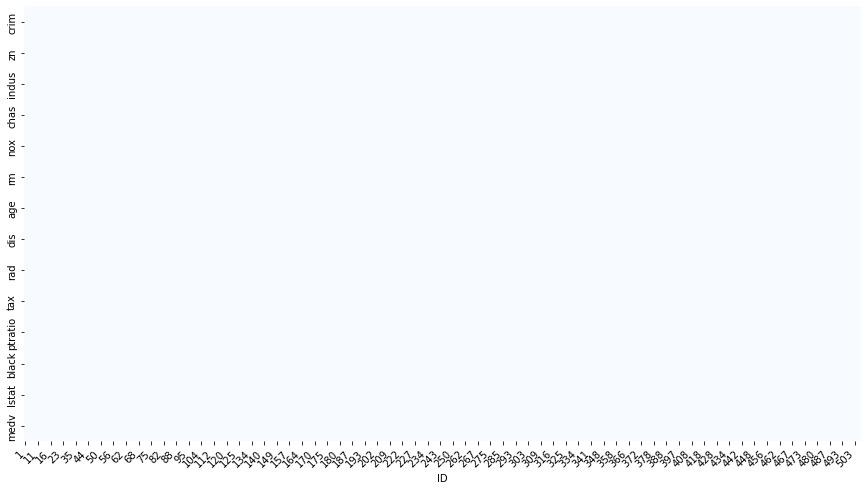

In [5]:
plot_missing_value(df)

# Dataset Splitting

In [6]:
# regresi pakai shuffle split, klasifikasi stritify split
X = df.drop(columns="medv")
y = df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((266, 13), (67, 13), (266,), (67,))

# Training

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [8]:
X_train.head()

crim   zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
ID                                                                              
340  0.05497  0.0   5.19     0  0.515  5.985  45.4  4.8122    5  224     20.2   
118  0.15098  0.0  10.01     0  0.547  6.021  82.6  2.7474    6  432     17.8   
456  4.75237  0.0  18.10     0  0.713  6.525  86.5  2.4358   24  666     20.2   
28   0.95577  0.0   8.14     0  0.538  6.047  88.8  4.4534    4  307     21.0   
43   0.14150  0.0   6.91     0  0.448  6.169   6.6  5.7209    3  233     17.9   

      black  lstat  
ID                  
340  396.90   9.74  
118  394.51  10.30  
456   50.92  18.13  
28   306.38  17.28  
43   383.37   5.81

In [9]:
X_train.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'],
      dtype='object')

In [10]:
X_train.drop(columns='chas').columns

Index(['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'],
      dtype='object')

In [11]:
gsp.rf_params

{'algo__n_estimators': [100, 150, 200],
 'algo__max_depth': [20, 50, 80],
 'algo__max_features': [0.3, 0.6, 0.8],
 'algo__min_samples_leaf': [1, 5, 10]}

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['crim', 'zn', 'indus', 'nox', 'rm', 
                             'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']),
    ('categoric', cat_pipe(), ['chas']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])



model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
0.9789454334689734 0.8394425941403533 0.9124500246015385


# Scaling membantu KNN dan SVM, tapi tidak untuk RF

karena scaling tidak berpengaruh ke algoritma berbasis tree, tapi rf bisa melakukan feature importance 

# Feature Importance

### Mean Loss Decrease

Kita akan melihat rata-rata pengurangan error/loss yang dikontibusikan oleh tiap fitur.

Untuk kasus klasifikasi, loss yang dipakat adalah gini-impurity, jadi sering juga disebut mean impurity decrease

untuk kasus regresi, loss yang dipakai adalah MSE, mungkin bisa disebut sebagai mean MSE decrease (?)

boleh coba cek tooltip dari random forest, loss yang dimaksud adalah criterion

Semakin besar loss yang berhasil diturunkan oleh suatu fitur, maka semakin penting fitur tersebut 

In [13]:
from jcopml.feature_importance import mean_loss_decrease

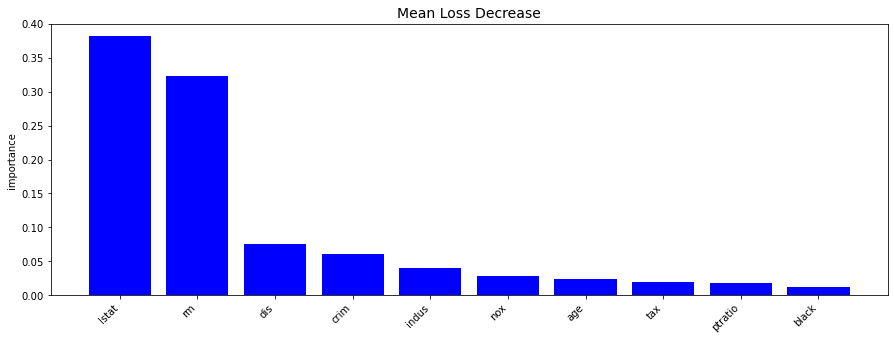

In [14]:
df_imp = mean_loss_decrease(X_train, model, plot=True, topk=10)

### Mean Score Decrease

Kita acak masing-masing variabel dan lihat berapa pengurangan score yang terjadi. Semakin besar penurunan score, artinya fitur itu semakin penitng

klasifikasi accuracy

regresi r square

In [15]:
from jcopml.feature_importance import mean_score_decrease

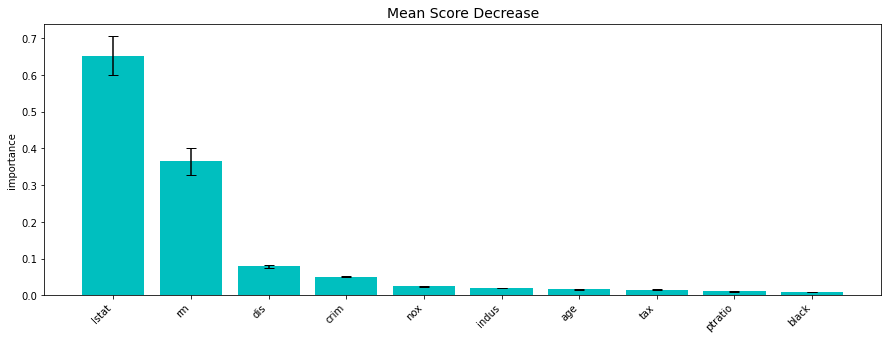

In [16]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

# Correlation-Causation Fallacy

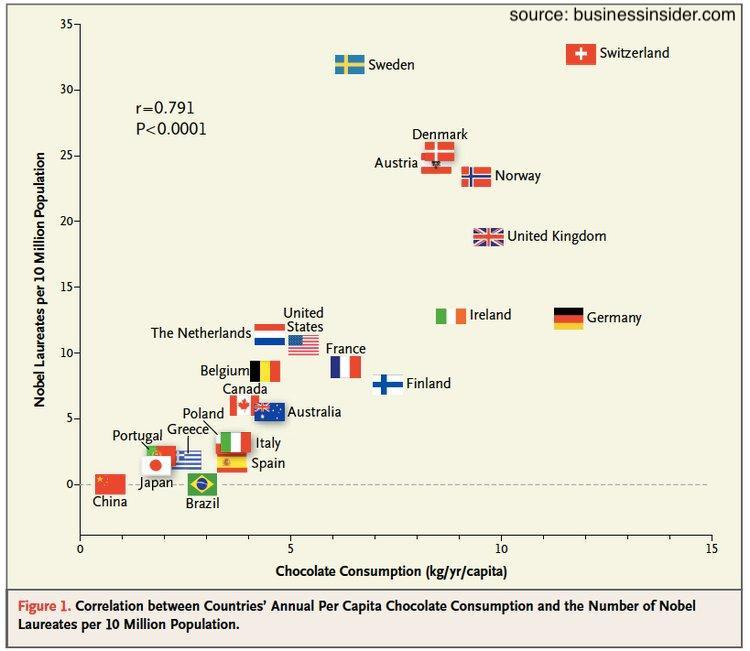

In [17]:
illustration.fallacy1

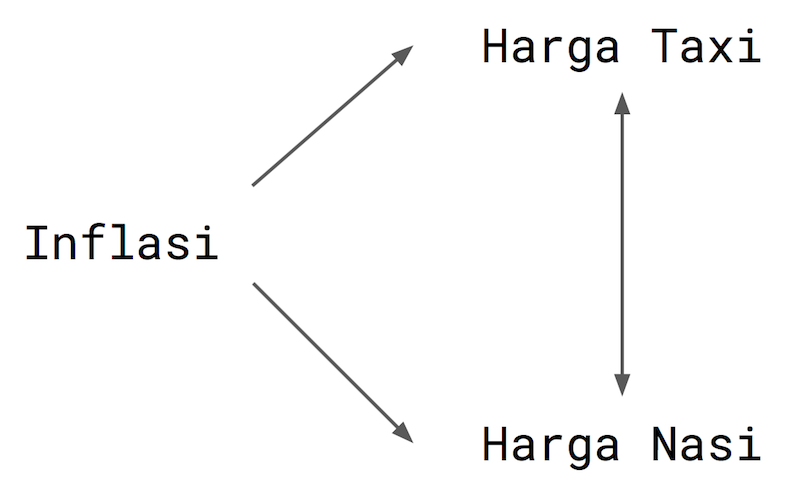

In [18]:
illustration.fallacy2

# Prediction

In [19]:
X_train.iloc[:1]

crim   zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
ID                                                                              
340  0.05497  0.0   5.19     0  0.515  5.985  45.4  4.8122    5  224     20.2   

     black  lstat  
ID                 
340  396.9   9.74

In [20]:
X_pred = pd.DataFrame([[0.01, 50, 3, 1, 0.8, 3, 20, 4, 1, 300, 10, 400, 5]], columns=X_train.columns)
X_pred

crim  zn  indus  chas  nox  rm  age  dis  rad  tax  ptratio  black  lstat
0  0.01  50      3     1  0.8   3   20    4    1  300       10    400      5

In [22]:
model.predict(X_pred)

array([25.701])

# Save Model

In [23]:
save_model(model.best_estimator_, "rf_house.pkl")

Model is pickled as model/rf_house.pkl
